In [2]:
from dotenv import load_dotenv

load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
add.invoke({"a": 1, "b": 2})

3

In [5]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [6]:
query = '3 곱하기 5는?'

In [7]:
multiply.invoke({'a': 3, 'b': 5})

15

In [8]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')

In [9]:
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JWAqCo6jHl5VqeqThLfXflMJ', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 84, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2f1b8588-f1f1-486f-8a13-cb6317886ccb-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_JWAqCo6jHl5VqeqThLfXflMJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 17, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [10]:
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_JWAqCo6jHl5VqeqThLfXflMJ')]}

In [11]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [12]:
def agent(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

In [13]:
def should_continue(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    
    if last_ai_message.tool_calls:
        return 'tools'
    return 'end'

In [14]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [15]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    {
        'tools': 'tools',
        'end': END
    }
)
graph_builder.add_edge('tools', 'agent')

In [17]:
graph = graph_builder.compile()

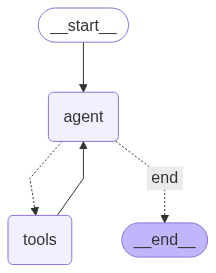

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))